In [21]:
# Refactoring tips : https://pytorch.org/tutorials/beginner/nn_tutorial.html
# Module forward hook : https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/
# Module, Sequential, and organizing better : https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md
# writing your own optimizer http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html
# torch tensor quick start operatiosn https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/
# SGD optimizer codein pytorch https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD.step
# Understanding torch nn Parameter https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter

# Not used:
# https://medium.com/pytorch/accelerate-your-hyperparameter-optimization-with-pytorchs-ecosystem-tools-bc17001b9a49


In [22]:
import os
import torch
from torch import nn
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt
#%matplotlib widgetb

In [23]:
# Helper functions

from os import sep
from pathlib import Path
import pickle

def pickleSave(object, name, folder: str):

    filename = Path(folder) / Path(name + '.pkl')
    print('Saving object {} to pickle file {}'.format(name, filename))
    with open(filename, mode='wb') as fipkl:    
        pickle.dump(object, fipkl)
        
def pickleLoad(name, folder: str):
    
    filename = Path(folder) / Path(name + '.pkl')
    print('Filename: ', filename)

    print('Loading object {} from pickle file {}'.format(name, filename))
    
    try:
        with open(filename, mode='rb') as fipkl:
            myObject=pickle.load(fipkl)
        return myObject
    except IOError:
        print('Pickle file {} not found, returning None object'.format(filename))
        return None


# Dataset

In [24]:
class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples = 200):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

# Dataloaders, get_data

In [25]:
def get_data(batch_size, num_samples):

    print(f'get_data: num samples requested = {num_samples}')
    datasets = {
        'train' : XORDataset(num_samples),  #num_samples
        'valid' : XORDataset(50),
    }
    loaders = {
    'train' : torch.utils.data.DataLoader(datasets['train'],  
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(datasets['valid'], 
                                          batch_size=10, 
                                          shuffle=True,
                                          num_workers=1),
    }
    return datasets, loaders
    

# Net model
## class XORnet

In [26]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()

        self.fc1=nn.Linear(2, 2)  # bias = True is default
        self.sig1=nn.Sigmoid()
        self.fc2=nn.Linear(2, 1)  # bias = True
        self.sig2=nn.Sigmoid()
        
        self.activations=[0 for i in range(3)] # 3 "layers" : input/hidden/output

        # custom weight initialization

        for layer in [self.fc1, self.fc2]:
            nn.init.normal_(layer.weight)


    def forward(self, x):
        '''Forward pass'''
        
        # not sure if necessary ?? I think it's breaking everything
        # torch.nn.init.constant_(self.fc1.bias.data,1)
        # torch.nn.init.constant_(self.fc2.bias.data,1)

        x2 = self.fc1(x)
        x2 = self.sig1(x2)
        x3 = self.fc2(x2)
        x3 = self.sig2(x3)
        self.store_activations(x, x2, x3)
        return x3

    def store_activations(self, x, x2, x3):
        self.activations[0] = x
        self.activations[1] = x2
        self.activations[2] = x3

# class statsLogger

In [27]:
from datetime import date, datetime
import pathlib

class statsLogger():
    def __init__(self, learner=None):
        self.accuracies=[]   # accuracy for each epoch
        self.losses=[]
        self.epochs=0
        self.minibatches=0
        self.samples=0
        self.all_minibatches_accuracies=[]  # accuracies for all minibatches in all epochs
        self.all_minibatches_losses=[]  # accuracies for all minibatches in all epochs
        self.learner = learner
        self.bs=None
        self.run_name=None

    def getRunName(self):
        if self.run_name == None:
            today = date.today()
            now=datetime.now().strftime("%H%M%S")
            run_name=f'{today}-{now}-'

            learner=self.learner

            if learner is not None:
                run_name+=f'{learner.model.__class__.__name__}-{learner.opt.__class__.__name__}-{learner.lr}-bs{self.bs}'
            self.run_name = run_name

        return self.run_name
        

    def startEpoch(self):
        self.epoch_total_samples=0
        self.epoch_total_minibatches=0
        self.epoch_correct_samples=0
        self.minibatch_losses=[]  # losses for all minibatches in the epoch
        

    def getMinibatchStats(self, pred, yb, loss, pref_fn=lambda pred : (pred>0.5).float() ):

        #Accuracy
        predicted = pref_fn(pred)
        minibatch_num_corrects = (predicted == yb).float().sum()
        minibatch_total = pred.shape[0]
        if self.bs == None:
            self.bs = minibatch_total
        self.epoch_total_samples += minibatch_total
        self.epoch_correct_samples += minibatch_num_corrects.item()
        self.minibatch_losses.append(loss.item())
        self.all_minibatches_losses.append(loss.item())
        self.all_minibatches_accuracies.append(100 *  minibatch_num_corrects.item() / minibatch_total)
        self.minibatches+=1
        self.epoch_total_minibatches+=1

    def endEpoch(self):
        self.losses.append(np.array(self.minibatch_losses).mean())
        epoch_accuracy = 100 * self.epoch_correct_samples / self.epoch_total_samples
        self.accuracies.append(epoch_accuracy)
        self.epochs+=1
        self.samples+=self.epoch_total_samples
        return epoch_accuracy

    def save(self, train_or_val: str, target_accuracy):

        learner = self.learner
        if learner is not None:
            filename=f'{train_or_val}-{learner.model.__class__.__name__}-{learner.opt.__class__.__name__}-lr{learner.lr}-bs{self.bs}.csv'
        else:
            filename=f'{train_or_val}-bs{self.bs}.csv'
          
        run_name = self.getRunName()
        epoch_with_target_accuracy_or_last_epoch = next((i+1 for i, acc in enumerate(self.accuracies) if acc >= 100), len(self.accuracies))
        print(f'Target accuracy of {target_accuracy} achieved at epoch {epoch_with_target_accuracy_or_last_epoch} : \
             loss {self.losses[epoch_with_target_accuracy_or_last_epoch-1]}, accuracy {self.accuracies[epoch_with_target_accuracy_or_last_epoch-1]}')
        info = {
            'run_name': [run_name],
            'target_epoch_accuracy': [target_accuracy],
            'epoch': [epoch_with_target_accuracy_or_last_epoch], 
            'epoch_loss': [self.losses[epoch_with_target_accuracy_or_last_epoch-1]],
            'epoch_accuracy': [self.accuracies[epoch_with_target_accuracy_or_last_epoch-1]]
        }

        file = pathlib.Path(filename)
        print(f'Saving epoch to reach target accuracy to {filename}')

        if file.exists ():

            df = pd.read_csv(filename)
            df2 = pd.DataFrame(info)
            result = pd.concat([df, df2])
            result.to_csv(filename, sep=',', index=None)
        else:

            df = pd.DataFrame(info)
            df.to_csv(filename, sep=',', index=None)
    

# Information Theory measures

## class ActivationsCollector

In [28]:
import pandas as pd
from datetime import date, datetime

class activationsCollector():
    def __init__(self, g):
        self.g = g
        # 5 because 2 input, 2 hidden layer neurons ad 1 output in perceptron ==> 5 activations to store
        self.neurons={}
        self.binNeurons={}
        self.targets=[]
        self.num_layers=0
        self.num_neurons_per_layer=[]
        self.bs=0

    def collect(self, model, yb):

        self.bs=yb.size()[0]         # the first dim of the activation tensor or target tensor is the number of samples in minibatch
        bs=self.bs

        # storing the targets
        self.targets.extend([yb[i].item() for i in range(bs)])

        activations=model.activations

        # Layer details initializations on first time use
        if self.num_layers==0:
            self.num_layers=len(activations)
            for l in range(self.num_layers):
                self.num_neurons_per_layer.append(activations[l].size()[1])  # the second dimensions of the activations in a layer is the number of neurons in that layer

        # collecting activations browing through the whole net model    
        for l in range(self.num_layers):
            # self.num_neurons_per_layer.append(activations[l].size()[1])

            #for neuron in range(activations[l].size()[1]): 
            for neuron in range(self.num_neurons_per_layer[l]): 

                neuron_name=f'{l}-{neuron}'
                if (neuron_name not in self.neurons):
                    self.neurons[neuron_name]=[]
                    self.binNeurons[neuron_name]=[]

                self.neurons[neuron_name].extend([activations[l][i, neuron].item() for i in range(bs)])
                self.binNeurons[neuron_name].extend([int(activations[l][i, neuron].item() > self.g) for i in range(bs)])

                #if neuron_name=='1-1':
                #print(f'Neuron {neuron_name}:')
                #print('activation:', [activations[l][i, neuron].item() for i in range(bs)])
                #print('discretized:', [int(activations[l][i, neuron].item() > self.g) for i in range(bs)])

    def save(self, run_name):

        filename=f'{run_name}-'

        name_neurons = filename + 'neurons-act.csv'
        name_bin_neurons = filename + f'thres{self.g}-bin-neurons-act.csv'
        df_neuron = pd.DataFrame(self.neurons)
        df_bin_neurons = pd.DataFrame(self.binNeurons)

        df_neuron.to_csv(name_neurons, sep=',', index=False)
        df_bin_neurons.to_csv(name_bin_neurons, sep=',', index=False)



## te calculator class

In [29]:
from jpype import startJVM, getDefaultJVMPath, JArray, JDouble, JInt, JPackage, shutdownJVM, isJVMStarted

javaIntList = lambda l : JArray(JInt, 1)(l)
javaDoubleList = lambda l : JArray(JDouble, 1)(l)
# import sys 
# Our python data file readers are a bit of a hack, python users will do better on this:
# sys.path.append("/home/jovyan/notebooks/jidt/demos/python")

# do we make the assumption that the process is stationary when calculating TE?
# what is the history length that we can consider ?

class teCalculator():
    def __init__(self, model, past, bs, calculator_params):
        self.past=past
        self.bs=bs
        self.model=model
        self.calculator_params=calculator_params

        self.__startJVM()

        self.teHistory={}
        self.teHistoryLocal={}
        self.miHistory={}
        self.miHistoryLocal={}
        self.tekHistory={}
        self.tekHistoryLocal={}
        self.mikHistory={}
        self.mikHistoryLocal={}

    def save(self, run_name):

        filename=f'{run_name}-'


        name_te = filename + 'interneuron-avgTE.csv'
        df_te = pd.DataFrame(self.teHistory)
        df_te.to_csv(name_te, sep=',', index=False)

        name_tek = filename + 'interneuron-avgTEK.csv'
        df_tek = pd.DataFrame(self.tekHistory)
        df_tek.to_csv(name_tek, sep=',', index=False)

        name_mi = filename + 'interlayer-avgMI.csv'
        df_mi = pd.DataFrame(self.miHistory)
        df_mi.to_csv(name_mi, sep=',', index=False)

        name_mik = filename + 'interlayer-avgMI.csv'
        df_mik = pd.DataFrame(self.mikHistory)
        df_mik.to_csv(name_mik, sep=',', index=False)      
        

    def __startJVM(self):
        # Add JIDT jar library to the path
        jarLocation = "/home/jovyan/notebooks/jidt/infodynamics.jar"
        # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
        if (not isJVMStarted()):
            startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)
    
    def __setupTECalculator(self, target_history, source_history):
        calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
        base=2
        k_history=target_history
        k_tau=1
        i_history=source_history
        i_tau=1
        delay=0
        calc = calcClass(base, k_history, k_tau, i_history, i_tau, delay)
        calc.initialise()

        return calc

    def __setupTEKraskovCalculator(self):
        calcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
        calc = calcClass()
        # 2. Set any properties to non-default values:
        calc.setProperty("DELAY", "0")
        # 3. Initialise the calculator for (re-)use:
        calc.initialise()

        return calc

    def __setupMICalculator(self):
        
        # 1. Construct the calculator:
        calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
        base=2
        time_difference=0
        calc = calcClass(base, base, time_difference)
        # 2. No other properties to set for discrete calculators.
        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        return calc

    def __setupMIKraskovCalculator(self):
        # 1. Construct the calculator:
        calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
        calc = calcClass()
        # 2. Set any properties to non-default values:
        # No properties were set to non-default values
        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        return calc

    def __extractTimeSeries(self, collector, neuron_i, neuron_j, past=0, binarized=True):

        source_layer, i = neuron_i
        target_layer, j = neuron_j

        if binarized==True:
            neurons = collector.binNeurons
        else:
            neurons = collector.neurons

        if past == 0:
            # take all we got to calculate time series
            source = neurons[f'{source_layer}-{i}']
            target = neurons[f'{target_layer}-{j}']
        else:
            # consider only the nearby "past"
            source = neurons[f'{source_layer}-{i}'][-past:]
            target = neurons[f'{target_layer}-{j}'][-past:]
        #print(f'{neuron_i} source activations: {source} - {neuron_j} : target activations {target}, past = {past}')

        return source, target

    def calculateMeasureBetweenNeurons(self, collector, neuron_i, neuron_j, past, calc_setup_fn, calc_name='discrete', p_value=100):

        # Setup for Kraskov TE - Need to use the non binarized neuron output and also not calculate bias,
        # because Kraskov is already bias corrected

        bias = True
        binarized = True
        if calc_name == 'kraskov':
            bias=False
            binarized=False
        
        # Extracting time series out of neurons activations stored in collector

        source, target = self.__extractTimeSeries(collector, neuron_i, neuron_j, self.past, binarized)
        number_of_samples=len(source)

        if binarized == True:
            source = javaIntList(source)
            target = javaIntList(target)
        else:
            source = javaDoubleList(source)
            target = javaDoubleList(target)

        # set up calculator
        calc=calc_setup_fn()

        # 4. Supply the sample data:
    
        if calc_name == 'kraskov':

            if number_of_samples >= past:
                calc.setObservations(source, target)
                result=float(calc.computeAverageLocalOfObservations())
                if p_value < 100:
                    measDist = calc.computeSignificance(100)
                    if measDist.pValue > p_value:
                        result=0
            else:
                result=0
                
            local_results=[]

        else:
            if number_of_samples >= past:
                calc.addObservations(source, target)
                result=float(calc.computeAverageLocalOfObservations())
                measDist = calc.computeSignificance()
                bias = measDist.getMeanOfDistribution()
                result-=float(bias)
                if p_value < 100:
                    measDist = calc.computeSignificance(100)
                    if float(measDist.pValue) > p_value:
                        result=0
            else:
                result=0
            
            # to do if I use local_results - add bias
            #TEMP to save time - local_results = calc.computeLocalFromPreviousObservations(source, target)
            local_results=[]
            
        return result, local_results

    def __getNeuronPairName(self, neuron_i, neuron_j):
        source_layer, i = neuron_i
        target_layer, j = neuron_j
        pair_name=f'{source_layer}-{i}-{target_layer}-{j}'
        return pair_name

    def __saveMeasure(self, pair_name, history, historyLocals, result, resultLocals):

        if (pair_name not in history):
            history[pair_name]=[]
            historyLocals[pair_name]=[]

        history[pair_name].append(result)
        historyLocals[pair_name].extend(resultLocals)

    def getLastValueInHistory(self, history, neuron_i, neuron_j):
        pair_name = self.__getNeuronPairName(neuron_i, neuron_j)
        if pair_name in history and len(history[pair_name]) > 0:
            return history[pair_name][-1:][0]
        else:
            return 0
    
    def getMeasuresForLayer(self, collector, source_layer, target_layer, measures={'te':True, 'mi':True, 'tek':True, 'mik': True}):
        
        num_sources=collector.num_neurons_per_layer[source_layer]
        num_targets=collector.num_neurons_per_layer[target_layer]

        for i in range(num_sources):
            for j in range(num_targets):

                neuron_i = (source_layer, i)
                neuron_j = (target_layer, j)
                pair_name = self.__getNeuronPairName(neuron_i, neuron_j)

                if measures['te']==True:

                    # Calculate transfer entropy between neurons

                    calc_setup_fn = lambda : self.__setupTECalculator(**self.calculator_params['te'])  
                    resultTE, local_resultsTE = self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn, p_value=100)

                    # Save average value and local values for each batch size

                    self.__saveMeasure(pair_name, self.teHistory, self.teHistoryLocal, resultTE, local_resultsTE[-self.bs:])

                if measures['mi']==True:
                    # Calculate MI between neurons

                    calc_setup_fn = lambda : self.__setupMICalculator()  
                    resultMI, local_resultsMI = self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn, p_value=100)

                    # Save average value and local values for each batch size

                    self.__saveMeasure(pair_name, self.miHistory, self.miHistoryLocal, resultMI, local_resultsMI[-self.bs:])

                if measures['tek']==True:
                    # Calculate TE Using non binarized values (!!! in nats)

                    calc_setup_fn = lambda : self.__setupTEKraskovCalculator()  
                    resultTEK, local_resultsTEK = \
                        self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn, calc_name='kraskov', p_value=100)

                    # Save average value and local values for each batch size

                    self.__saveMeasure(pair_name, self.tekHistory, self.tekHistoryLocal, resultTEK, local_resultsTEK[-self.bs:])

                if measures['mik']==True:
                    # Calculate MI Using non binarized values (!!! in nats)

                    calc_setup_fn = lambda : self.__setupMIKraskovCalculator()  
                    resultMIK, local_resultsMIK = \
                        self.calculateMeasureBetweenNeurons(collector, neuron_i, neuron_j, self.past, calc_setup_fn, calc_name='kraskov', p_value=100)

                    # Save average value and local values for each batch size

                    self.__saveMeasure(pair_name, self.mikHistory, self.mikHistoryLocal, resultMIK, local_resultsMIK[-self.bs:])
                
    def calculate(self, collector, measures):
        ''' Calculate Information Theory measures (discrete MI, TE or Kraskov MI, TE) 
        between neurons pairs
        Note: the layer 0 is the input layer, i.e. it contains the input data
         '''

        num_layers=collector.num_layers

        # for target_layer in range(1, num_layers):
        #    self.getMeasuresForLayer(collector, target_layer-1, target_layer)

        for source_layer in range(0, num_layers-1):
            for target_layer in range(source_layer+1, num_layers):
                self.getMeasuresForLayer(collector, source_layer, target_layer, measures)



## class TeParameters

In [30]:

class TeParameters:

    """Store the last calculated transfer entropies for each layer weights"""

    def __init__(self, model):
        self.te_params = self.__setupTEParameters(model)  #list of tensor same shape and order as model weights that will contain the corresponding te

    def __iter__(self):
        yield self.te_params

    def __call__(self):
        return self.te_params

    def update(self, model, calculator):
        '''Update the tensors containing the te values with the latest TE calculation value'''

        layer = 1
        for i, (name, parameter) in enumerate(model.named_parameters()):
            # this makes it specifc to a Linear module (the parameters containing the weights are called 'weight')
            if 'weight' in name:
                # this makes it specific to a "flat" network (input = 1d) i think
                for src_num_i in range(parameter.size()[1]-1):
                    for target_num_j in range(parameter.size()[0]-1):
                        neuron_i = (layer-1, src_num_i)
                        neuron_j = (layer, target_num_j)
                        # Note: we could update to calculate the value of te between neurons here instead of taking from history
                        self.te_params[i][src_num_i][target_num_j] = calculator.getLastValueInHistory(calculator.teHistory, neuron_i, neuron_j)

                #print(f'Updated TE for parameter {i} with name {name}: TE =  {self.te_params[i]}')
                layer=layer+1
            else:
                self.te_params[i]=None

    def __setupTEParameters(self, model):
        ''' Initialize tensors of same size as model weights (not including bias) to contain the transfer entropy'''

        te_params = []
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                te_param = torch.zeros_like(parameter, requires_grad=False)           
                te_params.append(te_param)
            else:
                te_params.append(None)
        return te_params

In [31]:
#---------------------------------------------------------
# Test Snippet for TEParameters
#---------------------------------------------------------


model=XORnet()
param = TeParameters(model)
calc_params = {
    'te': {
        'source_history': 1,
        'target_history': 1
    }
}
param.update(model, teCalculator(model, 40, 40, calc_params))
for p in param:
    print(p)

[tensor([[0., 0.],
        [0., 0.]]), None, tensor([[0., 0.]]), None]


# Optimizer

http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html     
https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD.step   
https://github.com/pytorch/pytorch/blob/master/torch/optim/_functional.py    


## F.sgd2

In [32]:
# Copied from https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py and updated 

from torch import Tensor
from typing import List, Optional

def sgd2(params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        *,
        weight_decay: float,
        momentum: float,    
        lr: float,
        dampening: float,
        nesterov: bool,
        te_params: List[Tensor]):

    for i, param in enumerate(params):

        d_p = d_p_list[i]
        if weight_decay != 0:
            d_p = d_p.add(param, alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        #print('param before descent:', param)
        if te_params is not None:
            te_param = te_params[i]
            if te_param is not None:
                #print('corresponding te_param:', te_param)
                param.add_(d_p * (1 - te_param), alpha=-lr)
            else:
                param.add_(d_p, alpha=-lr)
        else:     
            param.add_(d_p, alpha=-lr)
        #print('param after descent:', param)

## SGD2 Optimizer

In [33]:
# https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD.step
from torch.optim import Optimizer
from torch.optim import _functional as F

class SGD2(Optimizer):
    '''
    Implement backpropagation algorithm with a twist
    Using inter-neuron transfer entropy to change the weight update
    Wl:= Wl − η∆l(1 − tel)
    '''
    def __init__(self, params, te_params, lr=1e-3,momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):

        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))

        defaults = dict(te_params = te_params, lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD2, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD2, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            weight_decay = group['weight_decay']
            momentum_buffer_list = []
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            lr = group['lr']

            te_params=group['te_params']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]

                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            sgd2(params_with_grad,
                d_p_list,
                momentum_buffer_list,
                weight_decay=weight_decay,
                momentum=momentum,
                lr=lr,
                dampening=dampening,
                nesterov=nesterov,
                te_params=te_params)

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

# Learner class

In [34]:
class learner():

    def __init__(self, model, calculator, lr, opt_name, loss_fn=nn.MSELoss(), te_params=None):
        self.model = model
        self.calculator = calculator
        self.lr = lr
        self.loss_fn = loss_fn
        #print('learner lr:', lr)
        
        sgd2_te_params = None
        if te_params is not None:
            sgd2_te_params = te_params()
        #print('learner te_params:', sgd2_te_params)
        optimizers = {
            'adam': torch.optim.Adam(model.parameters(), lr = lr) ,
            'SGD': torch.optim.SGD(model.parameters(), lr = lr), 
            'SGD2': SGD2(model.parameters(),sgd2_te_params , lr = lr)
        }
        self.opt = optimizers[opt_name]

    def get_model(self):
        return self.model, self.opt, self.loss_fn

# Plot/save training stats

## plot per epoch

In [35]:
def plotTraining(loggers: list, learner: learner, run_name: str):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].losses, label='Train loss')
    axs[0].plot(loggers['valid'].losses, label='Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].accuracies, label='Train accuracy')
    axs[1].plot(loggers['valid'].accuracies, label='Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Accuracy')

    plt.legend()
    #plt.savefig(f'{run_name}-PlotEpoch.png')

    plt.show()

## plot per minibatch

In [36]:
def plotTrainingPerMiniBatch(loggers: list, learner: learner, run_name: str):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].all_minibatches_losses, label='Minibatch Train loss')
    #axs[0].plot(loggers['valid'].all_minibatches_losses, label='Minibatch Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Minibatches')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].all_minibatches_accuracies, label='Minibatch Train accuracy')
    #axs[1].plot(loggers['valid'].all_minibatches_accuracies, label='Minibatch Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('Minibatches')
    axs[1].set_ylabel('Accuracy')

    plt.legend()
    #plt.savefig(f'{run_name}-PlotMiniBatch.png')

    plt.show()

# fit() function

In [72]:
def fit(learner, loaders, epochs, collector, teCalc, teParams, target_accuracy, calculateITMeasures=True, measures={'te':True, 'mi':True, 'tek':True, 'mik': True}):

    model, optimizer, loss_fn = learner.get_model()
    trainLogger = statsLogger(learner)
    validLogger = statsLogger(learner)

    accuracy_reached=False
    accuracy_kept=0

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        ## training part 
        ##--------------

        model.train()
        for i, (xb, yb) in enumerate(loaders['train']):

            optimizer.zero_grad()

            ## 1. forward propagation
            pred = model(xb)

            if calculateITMeasures == True:
                # collect activations
                collector.collect(model, yb)
                # calculate measures
                teCalc.calculate(collector, measures)
                
                # TO DO: Only update for first epoch - Training Phase 1 - updating TEij to use for backprop
                if epoch == 1:
                    teParams.update(model, teCalc)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)

        epoch_accuracy = trainLogger.endEpoch()
        #print(f'Epoch {epoch} completed with accuracy {epoch_accuracy}, target accuracy = {target_accuracy}')
        if (epoch_accuracy == target_accuracy):
            accuracy_reached=True
            accuracy_kept+=1
        if (epoch_accuracy != target_accuracy):
            accuracy_reached=False
            accuracy_kept=0

        if (accuracy_kept == 5):
            print(f'break epoch loop')
            #break
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)

                validLogger.getMinibatchStats(pred, yb, loss)

            _ = validLogger.endEpoch()

    return { 'train' : trainLogger, 'valid' : validLogger }

# TRAINING !!! 

In [38]:
    
def train(lr=0.03, bs=40, num_samples=200, g=0.7, epochs=100, past=40, \
    opt_name='adam', calculator_params={'te':{'target_history':1, 'source_history':1}}, withTE=False, \
        calculateITMeasures=True, measures={'te':True, 'mi':True, 'tek':True, 'mik': True}):

    model=XORnet()

    _, loaders = get_data(bs, num_samples)

    activation_collector=activationsCollector(g)
    teCalc=teCalculator(model, past, bs, calculator_params)

    teParams=TeParameters(model)
    if withTE == True:                  # to update backpropgation algorithm using TE
        optimizer_teParams=teParams
        calculateITMeasures=True
        measures['te']=True
    else:
        optimizer_teParams=None

    Xorln = learner(model=model, calculator=teCalc, lr=lr, opt_name=opt_name, te_params=optimizer_teParams)

    
    print('=====================================================================================')
    print(f'Model         : {model}')
    print(f'Dataset size  : {num_samples}')
    print(f'Hyperparameter: lr {lr}')
    print(f'              : bs {bs}')
    print(f'              : maximum number of epochs {epochs}')
    print(f'              : optimizer {opt_name}')
    print(f'Training goal : reach 100% accuracy')
    print(f'Neuron activation binarization threshold g : {g} ')
    print(f'Information Theory measures parameters      : ')
    print(f'(1) Calculate Measures? {calculateITMeasures}')
    print(f'(2) Measures to collect: {measures}')
    print(f'(3) Use TE in backprop: {withTE} ')
    print('=====================================================================================')

    loggers = fit(Xorln, loaders, epochs, activation_collector, teCalc, teParams, target_accuracy=100, calculateITMeasures=calculateITMeasures, measures=measures)

    lg=loggers['train']
    print(f'{lg.epochs} epochs completed, epoch minibatches/samples: {lg.epoch_total_minibatches}/{lg.epoch_total_samples}, total minibs/samples:{lg.minibatches}/{lg.samples}')

    run_name = lg.getRunName()

    # Plot training

    plotTraining(loggers, Xorln, run_name)
    plotTrainingPerMiniBatch(loggers, Xorln, run_name)

    # Saving data

    print(f'Saving data for run {run_name}')
    activation_collector.save(run_name)
    teCalc.save(run_name)
    lg.save('Train', 100)

    return activation_collector, teCalc, lg

# java.lang.RuntimeException: java.lang.RuntimeException: Base and history combination too large

# MAIN

get_data: num samples requested = 200
Model         : XORnet(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (sig1): Sigmoid()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (sig2): Sigmoid()
)
Dataset size  : 200
Hyperparameter: lr 0.03
              : bs 40
              : maximum number of epochs 300
              : optimizer adam
Training goal : reach 100% accuracy
Neuron activation binarization threshold g : 0.7 
Information Theory measures parameters      : 
(1) Calculate Measures? True
(2) Measures to collect: {'te': False, 'mi': False, 'tek': True, 'mik': True}
(3) Use TE in backprop: False 
300 epochs completed, epoch minibatches/samples: 5/200, total minibs/samples:1500/60000


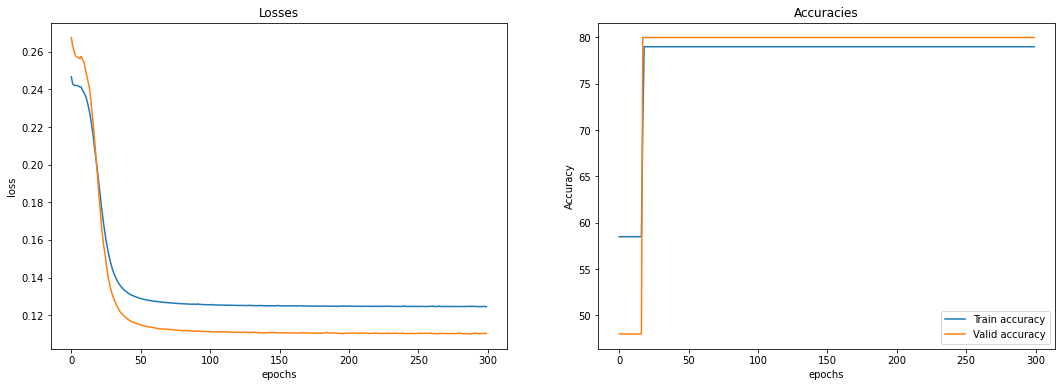

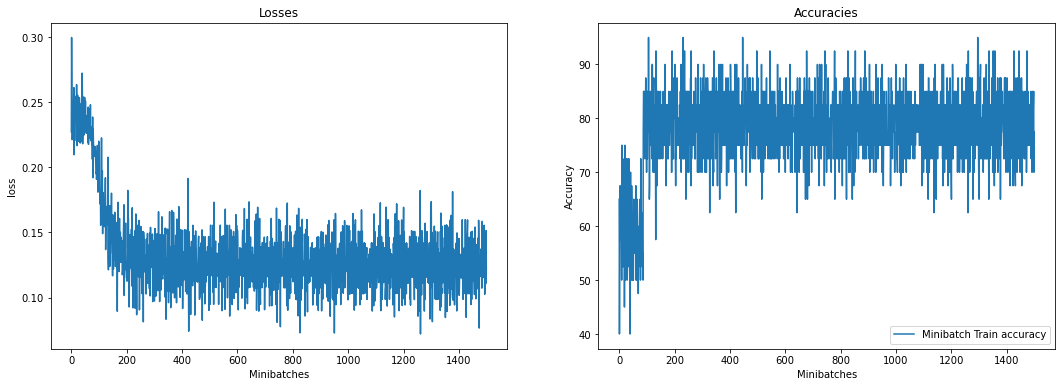

Saving data for run 2021-11-06-034934-XORnet-Adam-0.03-bs40
Target accuracy of 100 achieved at epoch 300 :              loss 0.1245718851685524, accuracy 79.0
Saving epoch to reach target accuracy to Train-XORnet-Adam-lr0.03-bs40.csv
lr 0.03 # epoch 100% acc or max 300 : acc 79.0 - losses 0.1245718851685524
Saving object 2021-11-06-034934-XORnet-Adam-0.03-bs40_300_result_dict to pickle file data/2021-11-06-034934-XORnet-Adam-0.03-bs40_300_result_dict.pkl
get_data: num samples requested = 200
Model         : XORnet(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (sig1): Sigmoid()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (sig2): Sigmoid()
)
Dataset size  : 200
Hyperparameter: lr 0.03
              : bs 40
              : maximum number of epochs 300
              : optimizer adam
Training goal : reach 100% accuracy
Neuron activation binarization threshold g : 0.7 
Information Theory measures parameters      : 
(1) Calculate Measures? True
(2) Measures to c

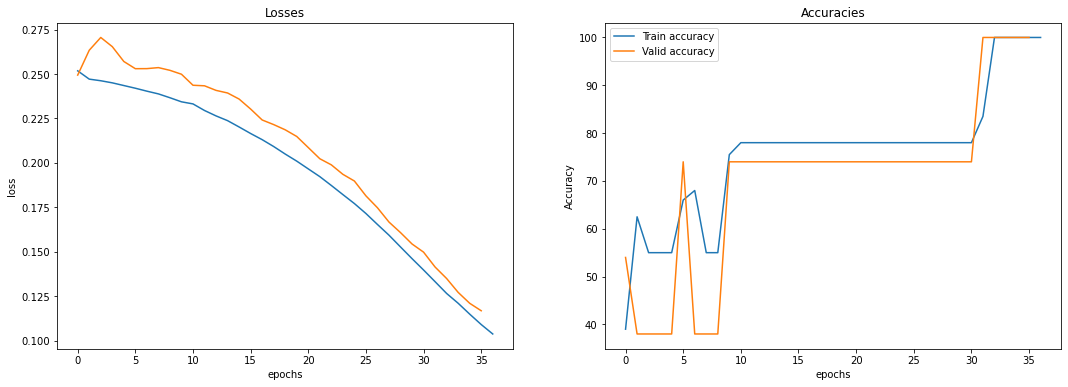

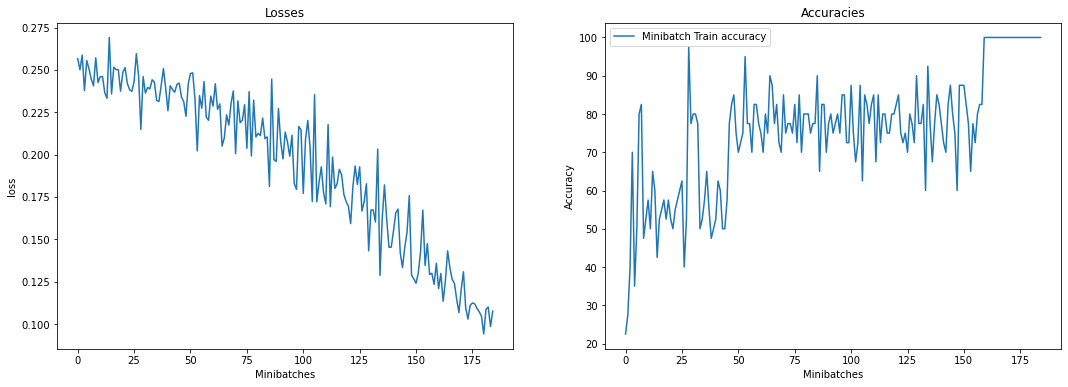

Saving data for run 2021-11-06-034950-XORnet-Adam-0.03-bs40
Target accuracy of 100 achieved at epoch 33 :              loss 0.12653280794620514, accuracy 100.0
Saving epoch to reach target accuracy to Train-XORnet-Adam-lr0.03-bs40.csv
lr 0.03 # epoch 100% acc or max 33 : acc 100.0 - losses 0.12653280794620514
Saving object 2021-11-06-034950-XORnet-Adam-0.03-bs40_33_result_dict to pickle file data/2021-11-06-034950-XORnet-Adam-0.03-bs40_33_result_dict.pkl


In [39]:

# Determined by looking for embedding using JIDT using activation time series (outside of this code)
calculator_params = {
    'te': {
        'target_history': 1,
        'source_history': 1
    }
}

#lrs = [ 0.03, 0.06, 0.12, 0.24 ]
lrs= [ 0.03 ]
for lr in lrs:

    for i in range(10):

        train_params = {
            'lr' : lr, #0.03, 0.025 in paper
            'bs' : 40,
            'past' : 40,
            'num_samples' : 200,
            'g' : 0.7,
            'epochs': 300, #100
            'opt_name': 'adam',
            'calculator_params': calculator_params,
            'withTE': False,   # using TE in backpropagation, only used with optimizer SGD2
            'calculateITMeasures': True,   # calculate IT Measures at each minibatch 
            'measures': {'te':False, 'mi':False, 'tek':True, 'mik': True}
        }

        activation_collector, teCalc, lg = train(**train_params)

        epochi = next((i+1 for i, acc in enumerate(lg.accuracies) if acc >= 100), train_params['epochs'])

        print(f'lr {lr} # epoch 100% acc or max {epochi} : acc {lg.accuracies[epochi-1]} - losses {lg.losses[epochi-1]}')

        result_dict = {
            'name': lg.getRunName(),
            'params': train_params,
            'collector': activation_collector,
            'calculator': teCalc,
            'logger': lg
        }
        
        pickleSave(result_dict, f'{lg.getRunName()}_{epochi}_result_dict', './data')

        if epochi < 300:
            break


In [40]:
lg.getRunName()

'2021-11-06-034950-XORnet-Adam-0.03-bs40'

In [41]:
# Training with TE in Backprop

# train_params_SGD2WithTE = {
#     'lr' : 0.01, #0.03, 0.025 in paper
#     'bs' : 40,
#     'past' : 40,
#     'num_samples' : 200,
#     'g' : 0.7,
#     'epochs': 300, #100
#     'opt_name': 'SGD2',
#     'calculator_params': calculator_params,
#     'withTE': True, # Use TE iun backprop
#     'calculateITMeasures': True,   # calculate IT Measures at each minibatch 
#     'measures': {'te':True, 'mi':False, 'tek':False, 'mik': False}
# }


# for i in range(1):
#     activation_collector, teCalc, lg = train(**train_params_SGD2WithTE)

In [42]:
teCalc_1 = teCalc

## Print activations

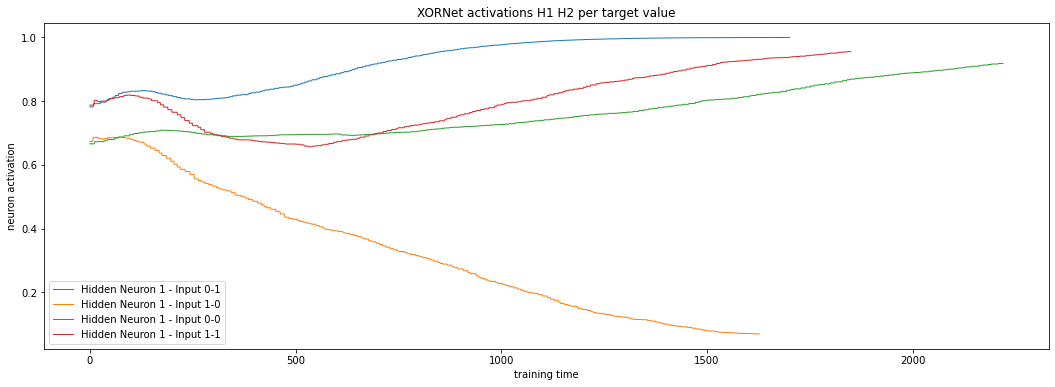

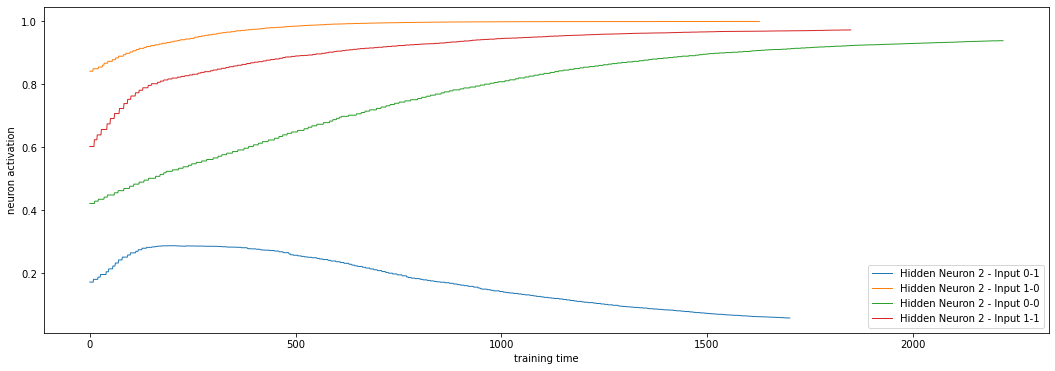

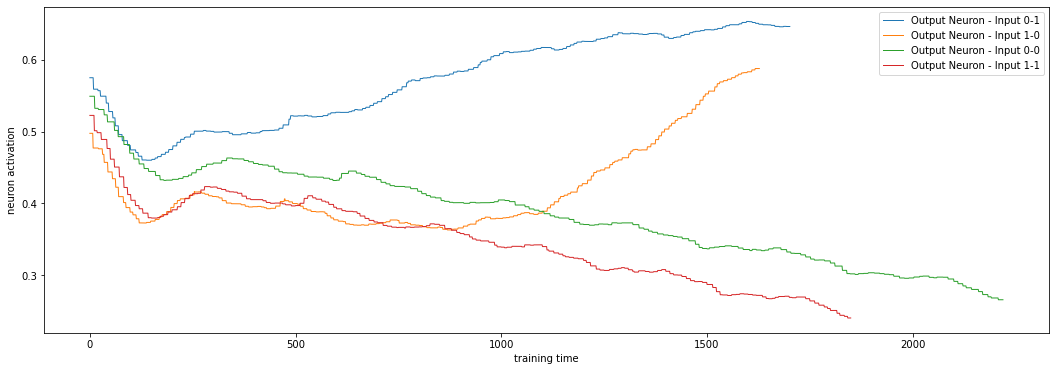

In [74]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2 per target value')

neurons = activation_collector.neurons

t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
i01_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 1 ]
i10_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 0 ]
i00_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 0 ]
i11_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 1 ]

axs.plot([ neurons['1-0'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-1')
axs.plot([ neurons['1-0'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-0')
axs.plot([ neurons['1-0'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-0')
axs.plot([ neurons['1-0'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-1')
# axs.plot([ activation_collector.neurons['1-0'][i] for i in t1_idx ],  linewidth=1, label='Hidden Neuron 1 - Target 1')

axs.set_xlabel('training time')
axs.set_ylabel('neuron activation')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ neurons['1-1'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-1')
axs.plot([ neurons['1-1'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-0')
axs.plot([ neurons['1-1'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-0')
axs.plot([ neurons['1-1'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-1')

axs.set_xlabel('training time')
axs.set_ylabel('neuron activation')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ neurons['2-0'][i] for i in i01_idx ], linewidth=1, label='Output Neuron - Input 0-1')
axs.plot([ neurons['2-0'][i] for i in i10_idx ], linewidth=1, label='Output Neuron - Input 1-0')
axs.plot([ neurons['2-0'][i] for i in i00_idx ], linewidth=1, label='Output Neuron - Input 0-0')
axs.plot([ neurons['2-0'][i] for i in i11_idx ], linewidth=1, label='Output Neuron - Input 1-1')

axs.set_xlabel('training time')
axs.set_ylabel('neuron activation')
plt.legend()
plt.show()

## Print TE

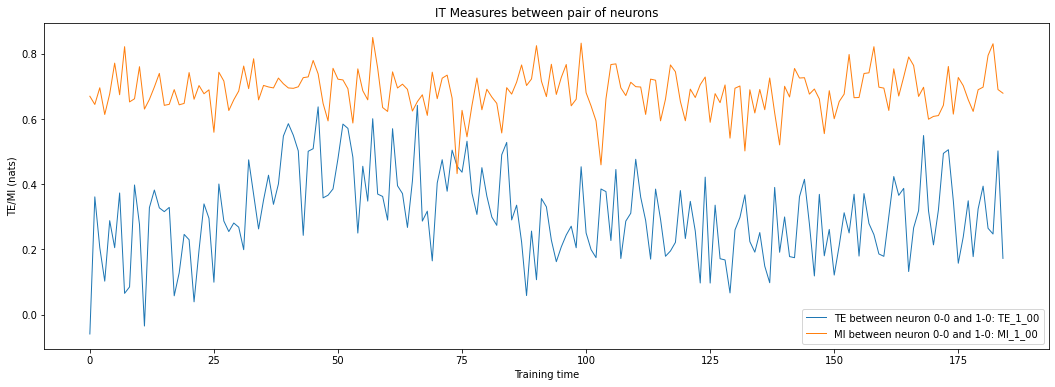

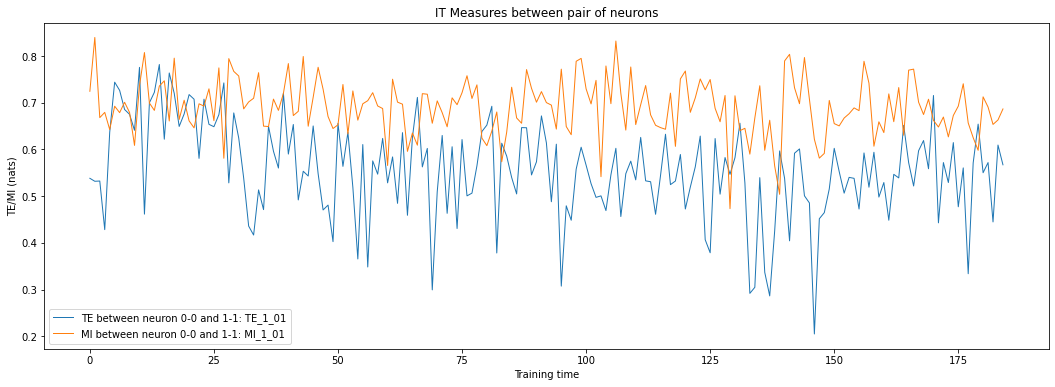

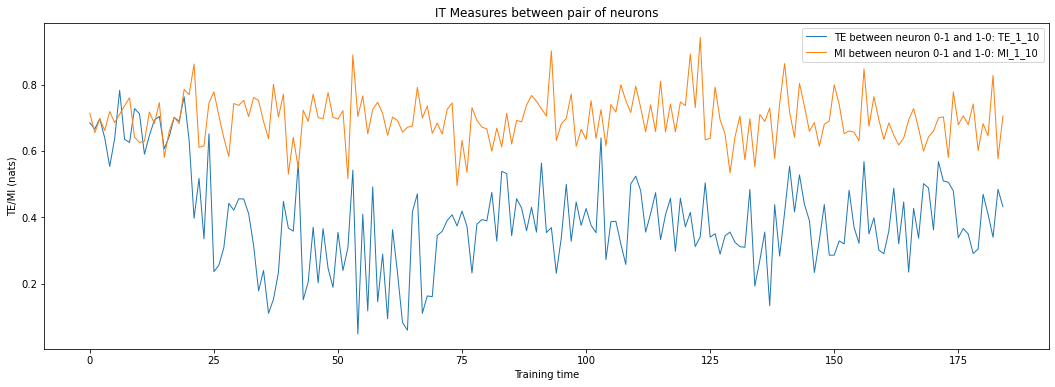

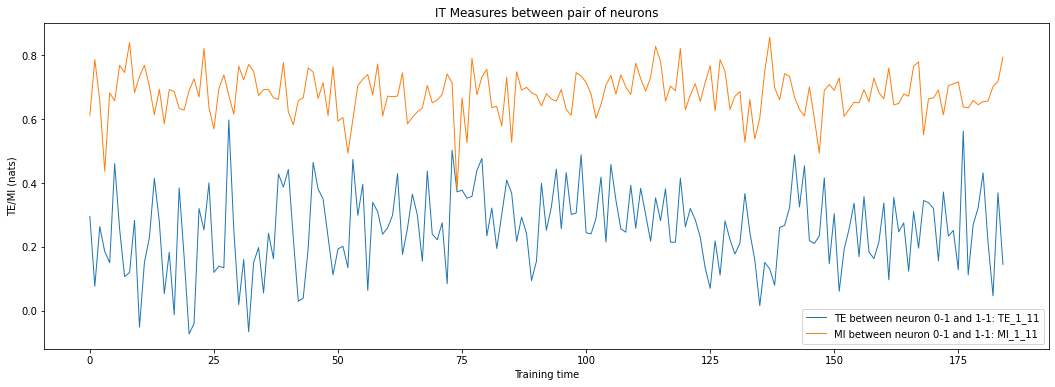

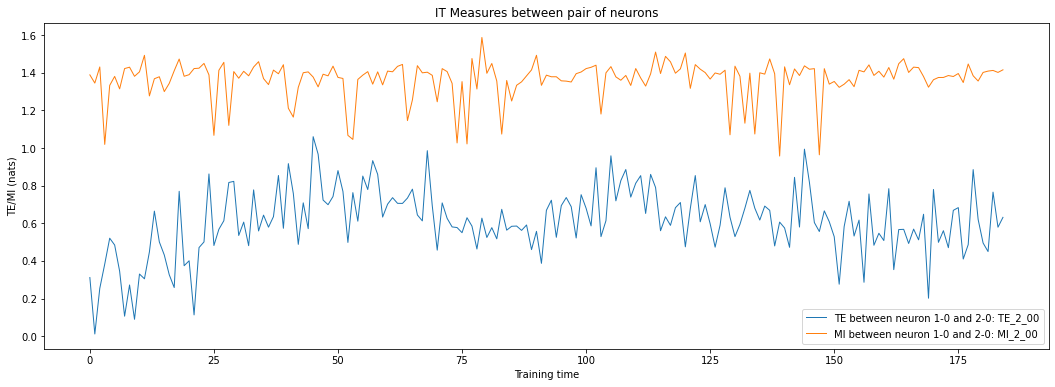

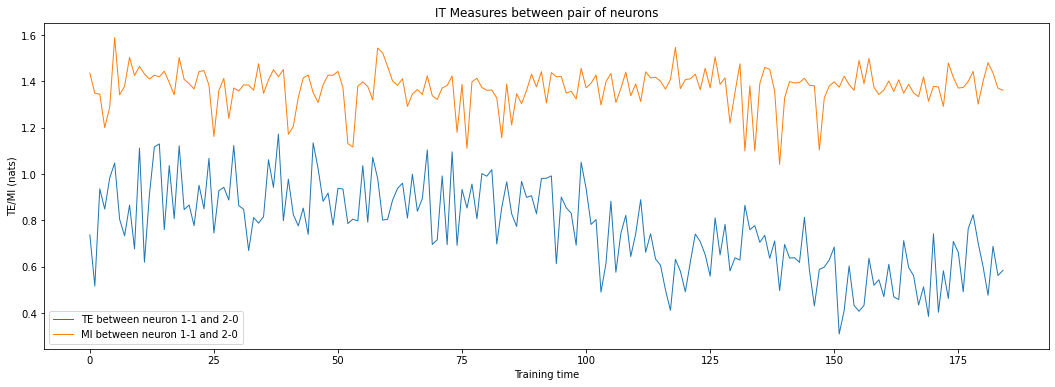

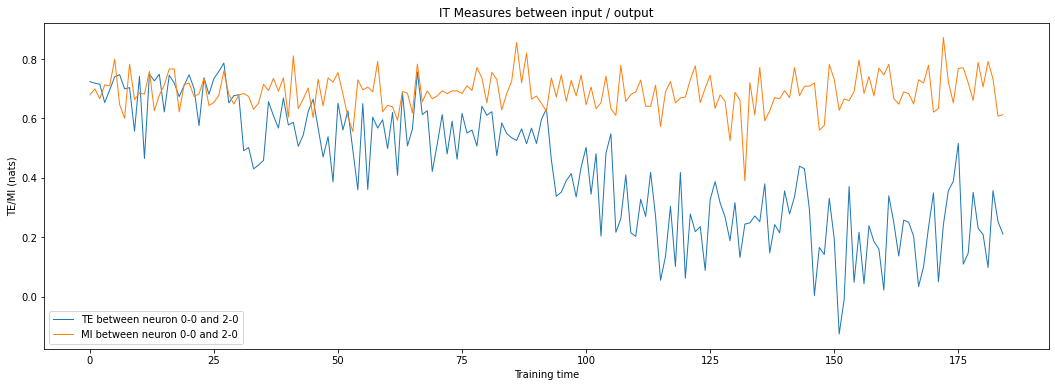

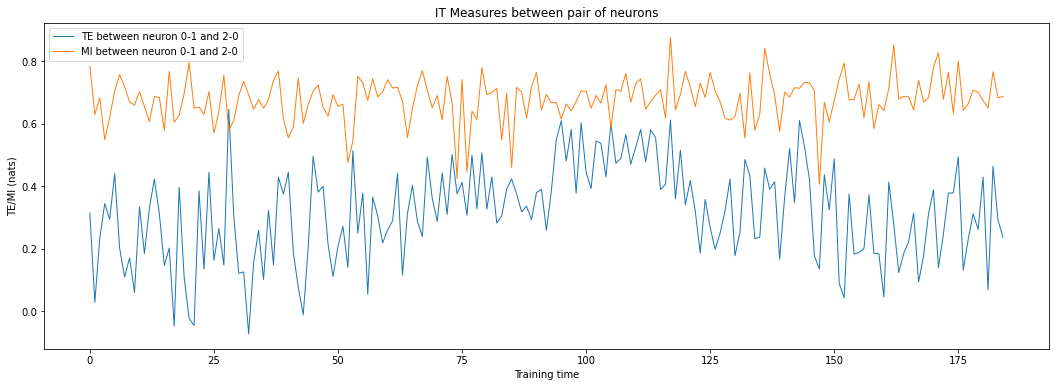

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
normalizl = lambda lst: scaler.fit_transform(np.array(lst).reshape(len(lst), 1))

# parameters : teCalculator 

# measures considered

historyte = teCalc.tekHistory #pd.DataFrame(teCalc.tekHistory)/np.log(2)  # kraskov te in bits
historymi = teCalc.mikHistory

# plots

# Input (2) => Hidden layer 1 (2) 

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between pair of neurons')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)') # when kraskov

axs.plot(historyte['0-0-1-0'], linewidth=1, label='TE between neuron 0-0 and 1-0: TE_1_00')
axs.plot(historymi['0-0-1-0'], linewidth=1, label='MI between neuron 0-0 and 1-0: MI_1_00')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between pair of neurons')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)')

axs.plot(historyte['0-0-1-1'], linewidth=1, label='TE between neuron 0-0 and 1-1: TE_1_01')
axs.plot(historymi['0-0-1-1'], linewidth=1, label='MI between neuron 0-0 and 1-1: MI_1_01')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between pair of neurons')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)')

axs.plot(historyte['0-1-1-0'], linewidth=1, label='TE between neuron 0-1 and 1-0: TE_1_10')
axs.plot(historymi['0-1-1-0'], linewidth=1, label='MI between neuron 0-1 and 1-0: MI_1_10')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between pair of neurons')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)')

axs.plot(historyte['0-1-1-1'], linewidth=1, label='TE between neuron 0-1 and 1-1: TE_1_11')
axs.plot(historymi['0-1-1-1'], linewidth=1, label='MI between neuron 0-1 and 1-1: MI_1_11')

plt.legend()
plt.show()

# Hidden Layer 1 - Output


fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between pair of neurons')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)')

axs.plot(historyte['1-0-2-0'], linewidth=1, label='TE between neuron 1-0 and 2-0: TE_2_00')
axs.plot(historymi['1-0-2-0'], linewidth=1, label='MI between neuron 1-0 and 2-0: MI_2_00')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between pair of neurons')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)')

axs.plot(historyte['1-1-2-0'], linewidth=1, label='TE between neuron 1-1 and 2-0')
axs.plot(historymi['1-1-2-0'], linewidth=1, label='MI between neuron 1-1 and 2-0')
plt.legend()
plt.show()

# Input output

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between input / output')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)')

axs.plot(historyte['0-0-2-0'], linewidth=1, label='TE between neuron 0-0 and 2-0')
axs.plot(historymi['0-0-2-0'], linewidth=1, label='MI between neuron 0-0 and 2-0')

plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('IT Measures between pair of neurons')
axs.set_xlabel('Training time')
axs.set_ylabel('TE/MI (nats)')

axs.plot(historyte['0-1-2-0'], linewidth=1, label='TE between neuron 0-1 and 2-0')
axs.plot(historymi['0-1-2-0'], linewidth=1, label='MI between neuron 0-1 and 2-0')
plt.legend()
plt.show()

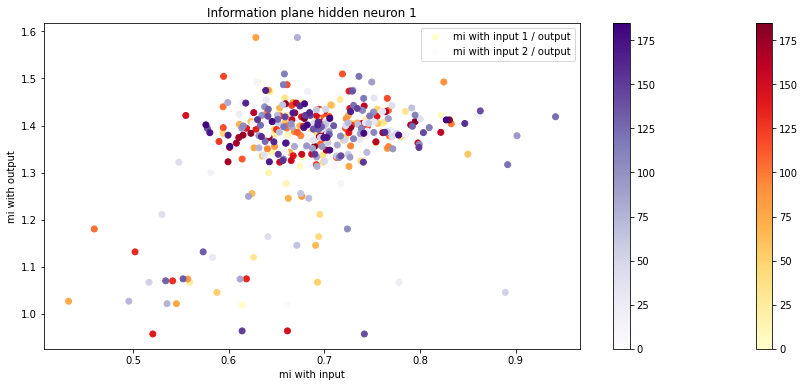

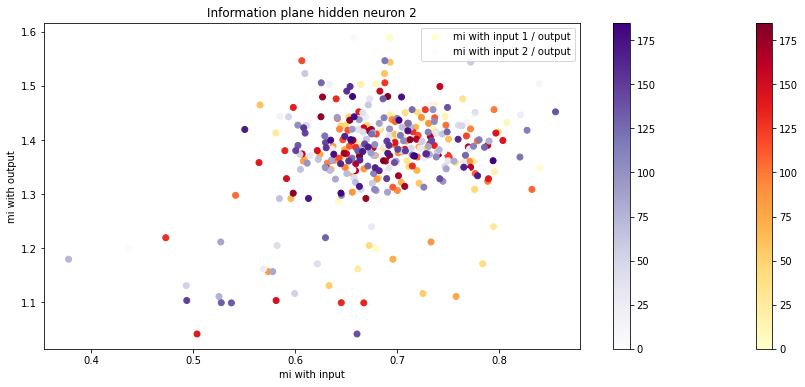

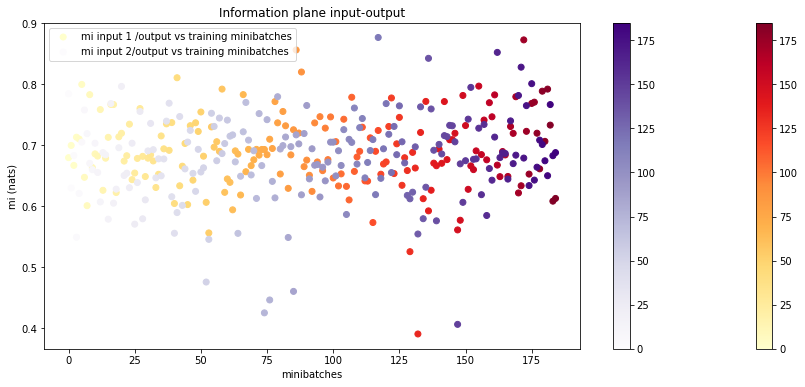

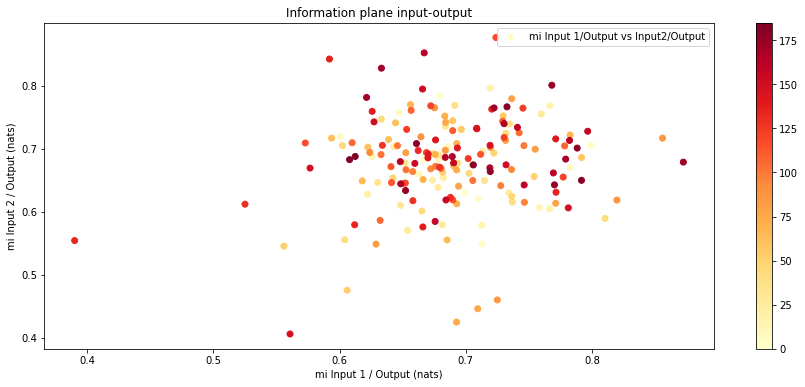

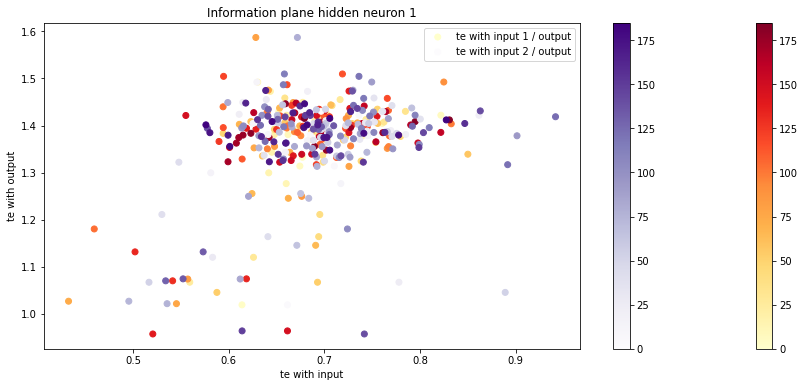

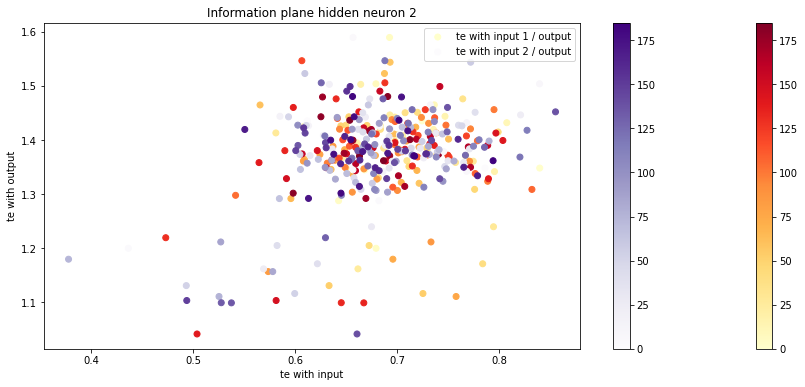

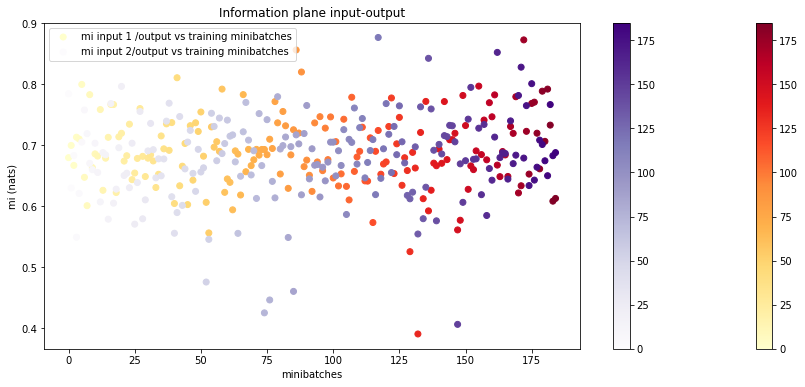

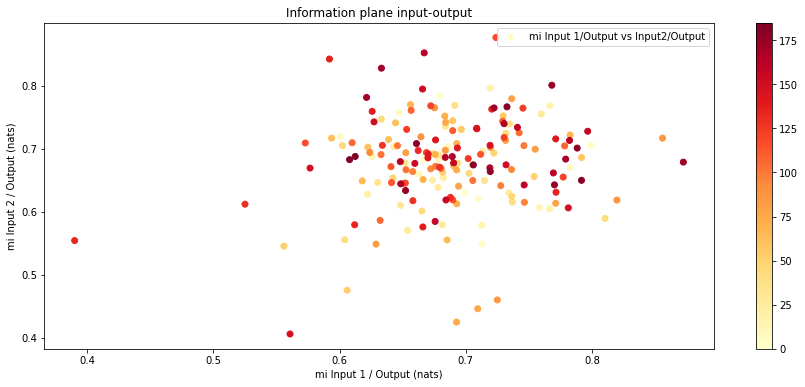

In [77]:

from matplotlib import cm
from matplotlib import colors

def infoPlane(x1,x2,y1, measure_name, neuron_name):
    cmap='YlOrRd'
    cmap2='Purples'

    norm=colors.Normalize(vmin=0, vmax=len(x1), clip=False)

    fig, axs= plt.subplots(1, 1, figsize=(15, 6))  
    plt.title(f'Information plane {neuron_name}')
    axs.set_xlabel(f'{measure_name} with input')
    axs.set_ylabel(f'{measure_name} with output')

    axs.scatter(x1, y1, c=[i for i in range(len(x1))], cmap=cmap, label=f'{measure_name} with input 1 / output')
    axs.scatter(x2, y1, c=[i for i in range(len(x1))], cmap=cmap2, label=f'{measure_name} with input 2 / output')
    fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), ax=axs)
    fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap2), ax=axs)

    plt.legend()
    plt.show()

def infoPlaneInputOutput(x1,x2,measure_name, neuron_name):
    cmap='YlOrRd'
    cmap2='Purples'

    norm=colors.Normalize(vmin=0, vmax=len(x1), clip=False)

    fig, axs= plt.subplots(1, 1, figsize=(15, 6))  
    plt.title(f'Information plane {neuron_name}')
    axs.set_xlabel(f'minibatches')
    axs.set_ylabel(f'{measure_name} (nats)')

    axs.scatter([i for i in range(len(x1))], x1, c=[i for i in range(len(x1))], cmap=cmap, label=f'{measure_name} input 1 /output vs training minibatches')
    axs.scatter([i for i in range(len(x1))], x2, c=[i for i in range(len(x1))], cmap=cmap2, label=f'{measure_name} input 2/output vs training minibatches')
    fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), ax=axs)
    fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap2), ax=axs)

    plt.legend()
    plt.show()

    fig, axs= plt.subplots(1, 1, figsize=(15, 6))  
    plt.title(f'Information plane {neuron_name}')
    axs.set_xlabel(f'{measure_name} Input 1 / Output (nats)')
    axs.set_ylabel(f'{measure_name} Input 2 / Output (nats)')

    axs.scatter(x1, x2, c=[i for i in range(len(x1))], cmap=cmap, label=f'{measure_name} Input 1/Output vs Input2/Output')
    fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), ax=axs)

    plt.legend()
    plt.show()

# MI with Input

history = teCalc.mikHistory

# Hidden Neuron 1


x1 = history['0-0-1-0']
x2 = history['0-1-1-0']
y1 = history['1-0-2-0']

infoPlane(x1,x2,y1, 'mi', 'hidden neuron 1')

# Hidden neuron 2

x1 = history['0-0-1-1']
x2 = history['0-1-1-1']
y1 = history['1-1-2-0']

infoPlane(x1,x2,y1, 'mi', 'hidden neuron 2')

# INput output

x1 = history['0-0-2-0']
x2 = history['0-1-2-0']

infoPlaneInputOutput(x1,x2, 'mi', 'input-output')

# TE with Input

historymi = teCalc.tekHistory

# Hidden Neuron 1


x1 = history['0-0-1-0']
x2 = history['0-1-1-0']
y1 = history['1-0-2-0']

infoPlane(x1,x2,y1, 'te', 'hidden neuron 1')

# Hidden neuron 2

x1 = history['0-0-1-1']
x2 = history['0-1-1-1']
y1 = history['1-1-2-0']

infoPlane(x1,x2,y1, 'te', 'hidden neuron 2')

# INput output

x1 = history['0-0-2-0']
x2 = history['0-1-2-0']

infoPlaneInputOutput(x1,x2, 'mi', 'input-output')


In [ ]:
historymi_df = pd.DataFrame(teCalc_1.mikHistory)

In [ ]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('Transfer entropies between each pair of neurons')

t0_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 0]
t1_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.targets[i] == 1]
i01_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 1 ]
i10_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 0 ]
i00_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 0 and activation_collector.neurons['0-1'][i] == 0 ]
i11_idx = [i for i in range(len(activation_collector.targets)) if activation_collector.neurons['0-0'][i] == 1 and activation_collector.neurons['0-1'][i] == 1 ]

axs.plot([ activation_collector.neurons['1-0'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-1')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 1 - Input 0-0')
axs.plot([ activation_collector.neurons['1-0'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 1 - Input 1-1')
# axs.plot([ activation_collector.neurons['1-0'][i] for i in t1_idx ],  linewidth=1, label='Hidden Neuron 1 - Target 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['1-1'][i] for i in i01_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-1')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i10_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i00_idx ], linewidth=1, label='Hidden Neuron 2 - Input 0-0')
axs.plot([ activation_collector.neurons['1-1'][i] for i in i11_idx ], linewidth=1, label='Hidden Neuron 2 - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
axs.plot([ activation_collector.neurons['2-0'][i] for i in i01_idx ], linewidth=1, label='Output Neuron - Input 0-1')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i10_idx ], linewidth=1, label='Output Neuron - Input 1-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i00_idx ], linewidth=1, label='Output Neuron - Input 0-0')
axs.plot([ activation_collector.neurons['2-0'][i] for i in i11_idx ], linewidth=1, label='Output Neuron - Input 1-1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')
plt.legend()
plt.show()

In [ ]:
fig, axs= plt.subplots(1, 1, figsize=(18, 6))  
plt.title('XORNet activations H1 H2')


axs.plot(activation_collector.neurons['1-0'], linestyle=":", linewidth=1, label='Hidden Neuron 1')

axs.set_xlabel('activations')
axs.set_ylabel('sample')

In [ ]:
x_in = torch.tensor([[1.0, 1.0]])

In [ ]:
model(x_in)

In [ ]:
model.activations

In [ ]:
model.fc1.weight, model.fc1.bias

In [ ]:
model.fc2.weight, model.fc2.bias

In [ ]:
for param in model.parameters():
    print('------------------------------------------')
    print(param)
    print(type(param))
    print(type(param.data), param.size())
    print(param.data)
    print(param.name)

In [ ]:
for name, parameter in model.named_parameters():
    if 'weight' in name:
        print(name, parameter)
        print(parameter.size()[1])

# optimizer

